# Sampling new models

In [1]:
import torch
from torch.utils.data import DataLoader
from guided_diffusion import *
from plotting_utils import *

In [2]:
input_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\input'
output_folder = r'C:\Users\u_imagenes\Documents\smerino\testing\target'

data = CustomDataset(input_folder, output_folder, transform=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

# UNET v10

In [3]:
# NOISE SCHEDULE
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)

In [4]:
BATCH_SIZE = 1
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

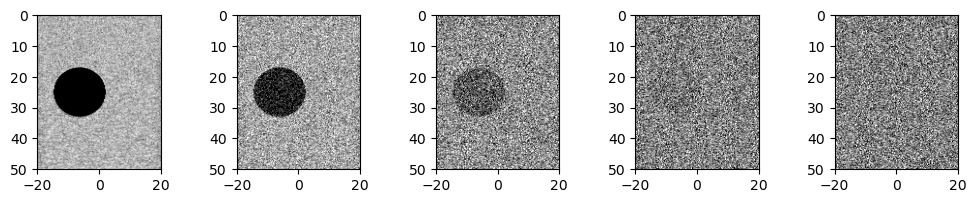

In [5]:
# FORWARD PROCESS
num_images = 5
stepsize = int(T/num_images)
plt.figure(figsize=(15,2))
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64).to(device)
    noise = torch.randn_like(y_sample)
    img = forward_process(y_sample, t, gamma, noise)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    show_tensor_image(img.cpu())
plt.show()

Num params:  31232993


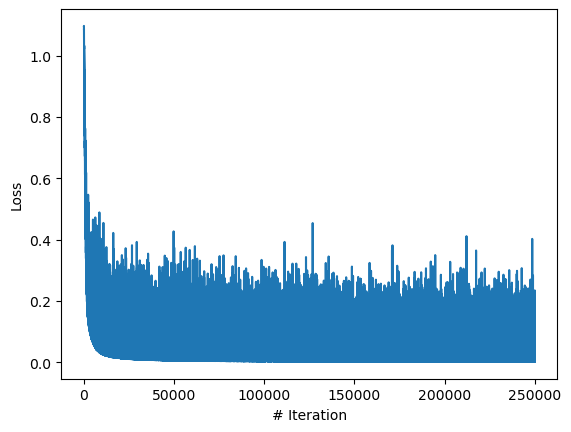

In [6]:
from model4 import UNETv10
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v10_T1000'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.plot(loss_npy)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.show()

100%|██████████| 1000/1000 [00:17<00:00, 57.82it/s]


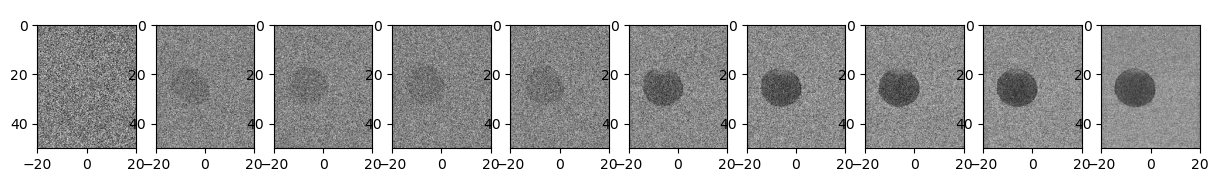

In [7]:
y_gen_clamp, intermediate_clamp = sample_image_cond(x_sample, model, beta, num_intermediate=10)
show_reverse_process(intermediate_clamp)

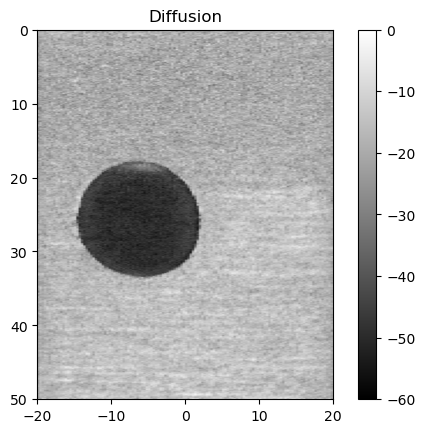

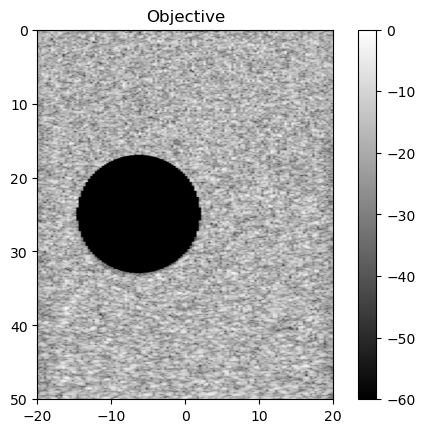

In [8]:
show_tensor_image(y_gen_clamp)
plt.colorbar()
plt.title('Diffusion')
plt.show()

show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.title('Objective')
plt.show()

## Evaluating noise prediction

Setting new batch size

In [9]:
BATCH_SIZE = 4
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

x_sample, y_sample = next(iter(dataloader))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)

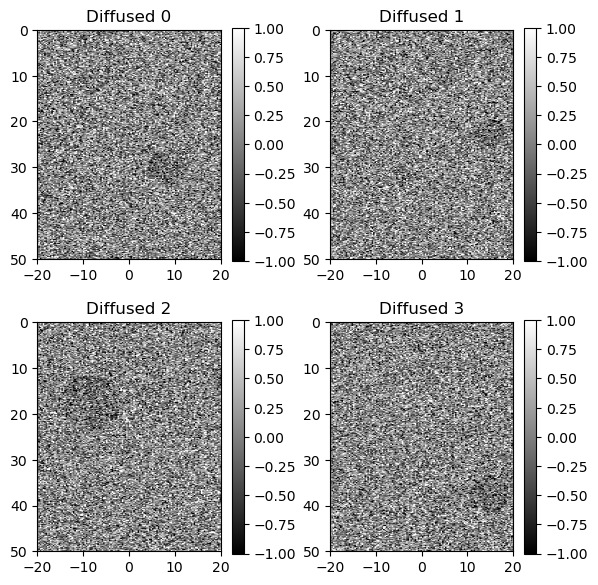

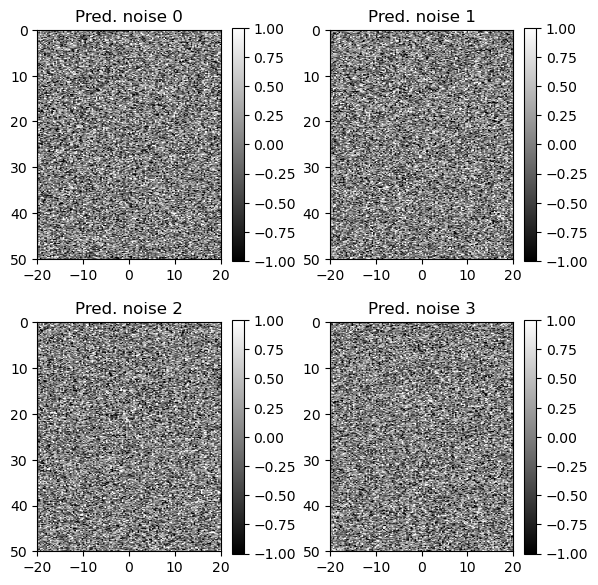

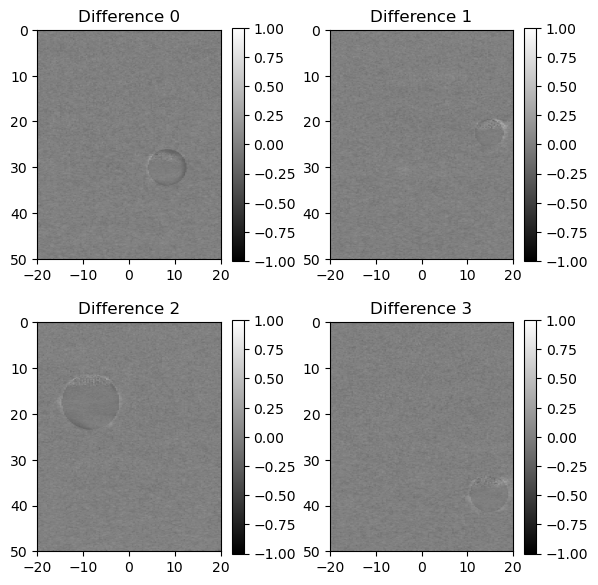

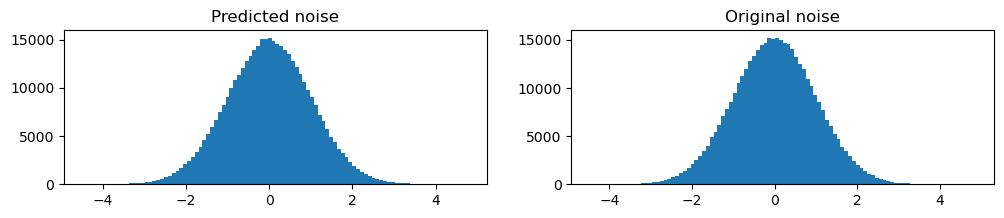

Predicted mean: -0.0011632012901827693, std: 1.0092182159423828
Original mean: 0.0012841526186093688, std: 0.9985161423683167
MSE: 0.002529991649037347


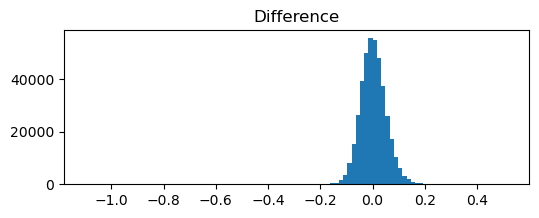

In [10]:
sample_timestep = 500
t = torch.Tensor([sample_timestep]*BATCH_SIZE).type(torch.int64).to(device)

noise = torch.randn_like(y_sample)
y_pert = forward_process(y_sample, t, gamma, noise)
input_model = torch.cat((x_sample.to(device), y_pert), 1)


plot_minibatch(y_pert, title="Diffused")
with torch.inference_mode():
    eps = model(input_model, t)
    predicted_noise = eps.detach().to('cpu').numpy().flatten()
    original_noise = noise.detach().to('cpu').numpy().flatten()

plot_minibatch(eps, title="Pred. noise")
plot_minibatch(eps - noise, title="Difference")
plt.figure(figsize=(12, 2))
plt.subplot(121)
plt.hist(predicted_noise, 100)
plt.title("Predicted noise")

plt.subplot(122)
plt.hist(original_noise, 100)
plt.title("Original noise")
plt.show()

print(f"Predicted mean: {np.mean(predicted_noise)}, std: {np.std(predicted_noise)}")
print(f"Original mean: {np.mean(original_noise)}, std: {np.std(original_noise)}")
print(f"MSE: {np.std(original_noise - predicted_noise) ** 2}")
plt.figure(figsize=(6, 2))
plt.hist(original_noise - predicted_noise, 100)
plt.title("Difference")
plt.show()